This module implements an algorithm to find a subset of an array 
with sum equal to a target number Using Qiskit, with theoretical
worst-case performance quadratically better than a naive search

Note: This assumes optimal choice for number of iterations of Grover's
operator, which can be done using quantum phase estimation
but has not yet been implemented.

In [1]:
import numpy as np

from qiskit import Aer, transpile
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import Diagonal, GroverOperator, PhaseEstimation
from qiskit.circuit.library.basis_change.qft import QFT
from qiskit.tools.visualization import plot_histogram

In [2]:
TAU = 2 * np.pi

In [3]:
def num_qubits(n_keys, total):
    """Calculate number of qubits needed in quantum regs for subset search"""
    n_value_qubits = int(np.ceil(np.log2(total)))
    n_total_qubits = n_keys + n_value_qubits
    return n_value_qubits, n_total_qubits


In [4]:
def exp_sums_circuit(values):
    """
    Unitary circuit that, applied to binary state, will give exponentiated sum
    of values in array positions where binary state bits equal 1
    """
    qc = QuantumCircuit(len(values))
    for i, val in enumerate(reversed(values)):
        qc.p(TAU * val, i)
    return qc

In [5]:
def initialize_circuit(n_value_qubits, 
                       n_keys, 
                       n_ancillas=0,
                       n_classical=0,
                       name=None):
    """Create new circuit with specified register sizes"""
    ns = [n_value_qubits, n_keys]
    if n_ancillas:
        ns.append(n_ancillas)
    regs = [QuantumRegister(n) for n in ns]
    if n_classical:
        regs.append(ClassicalRegister(n_classical))
    return QuantumCircuit(*regs, name=name), *regs

In [6]:
def sums_preparation_circuit(U, n_value_qubits, n_keys, name=None):
    """
    Circuit to create superposition of exponentiation of all possible sums of 
    elements in values array
    """
    sums_prep, sum_reg, key_reg = initialize_circuit(n_value_qubits, 
                                                     n_keys, 
                                                     name=name)
    sums_prep.h(sum_reg)
    sums_prep.h(key_reg)
    
    repetitions = 1
    for sum_qubit in reversed(sum_reg):
        for _ in range(repetitions):
            sums_prep.append(U.control(), [sum_qubit] + key_reg[:])
        repetitions *= 2

    qft_dagger = QFT(n_value_qubits, do_swaps=False, inverse=True)
    sums_prep.append(qft_dagger, sum_reg)
    return sums_prep


In [7]:
def oracle_circuit(target, n_value_qubits, n_keys, name=None):
    """
    Circuit which applies phase flip to states with binary representation
    equal to target
    """
    target_array = np.zeros(2 ** n_value_qubits)
    target_array[target] = 1
    diag = Diagonal((-1) ** target_array)
    
    oracle, sum_reg, key_reg = initialize_circuit(n_value_qubits, 
                                                  n_keys, 
                                                  name=name)
    oracle.append(diag, sum_reg[:])
    return oracle

In [8]:
def grover_circuit(oracle, sums_prep, n_value_qubits, name=None):
    """
    Grover iteration circuit
    """
    return GroverOperator(oracle,
                          state_preparation=sums_prep,
                          insert_barriers=True,
                          mcx_mode='v-chain',
                          name=name)


In [9]:
def estimate_iterations(values, target):
    """
    Estimated optimal number of iterations for subset sum Grover search
    """
    # TODO: Implement this statisticallly e.g. using Irwin-Hall distribution
    # or better yet with a Quantum Counting algorithm
    raise NotImplementedError

In [10]:
def subset_sum_circuit(values, target, iterations=None):
    """
    Circuit which finds subsets of values array with sum equal to target with
    high probability, in O(2^(n/2)) time where n=number of elements in target
    array, assuming fixed number of bits per value and optimal number of
    iterations
    """
    n_keys = len(values)
    total = sum(values)
    n_value_qubits, n_total_qubits = num_qubits(n_keys, total)
    
    values_normed = values / (2 ** n_value_qubits)
    U = exp_sums_circuit(values_normed)
    sums_prep = sums_preparation_circuit(U, n_value_qubits, n_keys, name='SP')
    oracle = oracle_circuit(target, n_value_qubits, n_keys, name='O')
    grover_op = grover_circuit(oracle, sums_prep, n_value_qubits, name='Q') 
    n_ancillas = len(grover_op.ancillas)
    
    if iterations is None:
        iterations = estimate_iterations
    
    qc, sum_reg, key_reg, _, _ = initialize_circuit(n_value_qubits, 
                                                    n_keys,
                                                    n_ancillas=n_ancillas,
                                                    n_classical=n_keys,
                                                    name='subset_sum')
    qc.append(sums_prep, sum_reg[:] + key_reg[:])
    for _ in range(iterations):
        qc.append(grover_op, qc.qubits)
    qc.measure(key_reg, qc.clbits)
    return qc

In [11]:
simulator = Aer.get_backend('qasm_simulator')

In [12]:
vs = np.array([5, 7, 8, 9, 1])
targ = 16
iterations = 2

qc = subset_sum_circuit(vs, targ, iterations=iterations)
qc = transpile(qc, simulator)
result = simulator.run(qc).result()
counts = result.get_counts(qc)

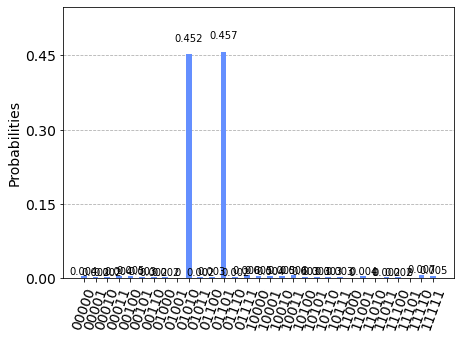

In [13]:
plot_histogram(counts)